In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__


Using TensorFlow backend.


'2.1.0'

In [2]:
# Function definitions

def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def load_image(image_path, img, resized_fac = 1):
    img     = cv2.imread(image_path + img)
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

def get_embedding(model, img_path, img_name):
    # Reshape
    img = image.load_img(img_path + img_name, target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

def get_recommender(indices, idx, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

def get_recommendation(similarity_matrix, idx, top_n = 5):
    scores = list(enumerate(similarity_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    scores = scores[1:top_n + 1]
    return scores

def get_first_filename_startswith(files_dict, prefix):
    files_dict


In [13]:
# Dataset definition
DATA_SET = 'myntra'

if DATA_SET == 'farfetch':
    BASE_PATH = 'D:\machine-learning\datasets\\farfetch-listings\\'
    IMAGE_PATH = BASE_PATH + 'cutout-img\processed\\'
elif DATA_SET == 'myntra':
    BASE_PATH = 'D:\\machine-learning\\datasets\\fashion-product-images-small\\myntradataset\\'
    IMAGE_PATH = BASE_PATH + 'images\\'
else:
    raise Error('Unexpected dataset')
    
# print(os.listdir(IMAGE_PATH)[:10])

In [14]:
# Save farfetch brand list into a CSV for lead-generation
# df['brand.name'].value_counts().sort_values(ascending=False).to_csv("C:\\Users\\User\\Downloads\\brand-list.csv")
#df['brand.name']
# Create data frame from image folder
df_image_folder = pd.DataFrame(os.listdir(IMAGE_PATH), columns=['name'])
df_image_folder = df_image_folder.reset_index(drop=True)
df_image_folder['name'][0]

'10000.jpg'

In [5]:
# Input Shape
#img_width, img_height, _ = load_image(IMAGE_PATH, df.iloc[0].image).shape
#img_width, img_height, _ = load_image(IMAGE_PATH, df.iloc[0].image).shape
#img_width, img_height, _ = 224, 224, 3
img_width, img_height, _ = load_image(IMAGE_PATH, df_image_folder.iloc[0][0]).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

C:\Users\User\Anaconda3\envs\cnn\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
# Try out the embedding once, see if it works
#emb = get_embedding(model, IMAGE_PATH, df.iloc[0].image)
emb = get_embedding(model, IMAGE_PATH, df_image_folder.iloc[0][0])
emb.shape

(2048,)

(80, 60, 3)
[0.09998199 1.2708011  4.925384   ... 0.20934463 1.5759482  1.515537  ]


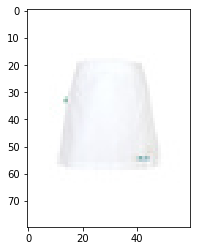

In [19]:
# img_array = load_image(IMAGE_PATH, df.iloc[0].image)
img_array = load_image(IMAGE_PATH, df_image_folder.iloc[0][0])
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [36]:
map_embeddings = df_image_folder[0:5]['name']
print(map_embeddings)

0    10000.jpg
1    10001.jpg
2    10002.jpg
3    10003.jpg
4    10004.jpg
Name: name, dtype: object


In [37]:
%%time
#import swifter

# Source from CSV
# Parallel apply
#df_sample      = df.sample(500)
#map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, IMAGE_PATH, img))
# Source from image folder directly

# Source from folder directly
map_embeddings = df_image_folder[0:5000]['name'].apply(lambda img: get_embedding(model, IMAGE_PATH, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

(5000, 2048)
Wall time: 18min 52s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.099982,1.270801,4.925384,0.00000,0.000000,0.000000,0.000000,0.276951,0.893493,0.000000,...,0.000000,0.000000,1.245008,0.000000,0.000000,0.000000,3.609418,0.209345,1.575948,1.515537
1,0.000000,2.745010,0.000000,0.00000,10.589779,4.606511,2.530780,3.350651,0.000000,0.000000,...,0.826959,0.000000,1.730045,0.000000,0.000000,0.241079,0.647665,0.000000,2.544854,7.604298
2,0.000000,3.402556,2.577542,0.00000,2.923137,3.250218,0.606352,1.925450,0.000000,0.000000,...,0.000000,0.000000,0.648463,0.000000,2.098540,0.000000,1.026958,0.000000,0.000000,6.455042
3,0.195940,19.293938,4.028438,0.00000,0.000000,6.786288,0.000000,0.162408,4.108119,0.189785,...,1.037168,0.088405,2.396965,2.589875,2.035435,0.000000,8.821429,0.000000,2.902439,13.621208
4,0.304436,7.557014,0.000000,2.77527,0.142011,1.165267,0.000000,7.130860,2.403404,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.641698,0.671759,0.000000,0.998073,7.229319


In [9]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')

cosine_sim[:4, :4]

array([[1.        , 0.24704456, 0.21707928, 0.18849671],
       [0.24704456, 1.        , 0.25805402, 0.4160623 ],
       [0.21707928, 0.25805402, 1.        , 0.2845739 ],
       [0.18849671, 0.4160623 , 0.2845739 , 0.9999994 ]], dtype=float32)

In [10]:
print(cosine_sim[0])

[1.         0.24704456 0.21707928 ... 0.30759078 0.68229353 0.43505585]


In [11]:
# indices = pd.Series(range(len(df_embs)), index=df.index)
print(get_recommendation(cosine_sim, 133, top_n = 5))
# print(indices)

[(2617, 0.7274262), (3783, 0.68677723), (2067, 0.6465361), (2479, 0.6212291), (4356, 0.6030657)]


[(2070, 0.78056544), (1119, 0.74829847), (1683, 0.7371534), (4002, 0.7331656), (764, 0.72935647)]


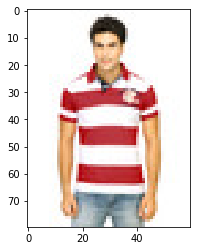

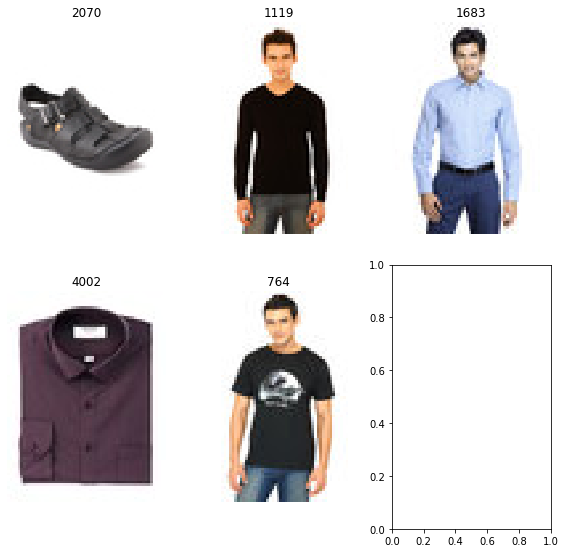

In [18]:
# Idx Item to Recommender
idx_ref = 3908


# Recommendations
#idx_rec, idx_sim = get_recommender(indices, idx_ref, top_n = 6)

recommendations = get_recommendation(cosine_sim, idx_ref, top_n = 5)
print(recommendations)


# Plot
#===================
# plt.imshow(cv2.cvtColor(load_image(IMAGE_PATH, df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(load_image(IMAGE_PATH, df_image_folder.iloc[idx_ref][0]), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
#figures = {'im'+str(i): load_image(IMAGE_PATH,row.image) for i, row in df.loc[idx_rec].iterrows()}
# figures = {'im'+str(i): load_image(IMAGE_PATH,row[0]) for i, row in df_image_folder.loc[idx_rec].iterrows()}

figures = {}
for rec in recommendations:
    figures[rec[0]] = load_image(IMAGE_PATH, df_image_folder.loc[rec[0]][0])
# figures = {'im'+str(rec[1]): load_image(IMAGE_PATH, df_image_folder.loc[rec[0]][0]) }
#print(figures)
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)